# UN Handbook on Remote Sensing for Agricultural Statistics
## Chapter 6: WorldCereal – A Global Effort for Crop Mapping
<hr style="border:0; border-top:1px solid #ccc; margin:12px 0 20px;">

<div style="margin-left:120px; display:flex; align-items:center;">
  <img src="../resources/ESA_logo.jpg" width="200" height="100" alt="ESA" style="vertical-align:middle;">
  <img src="../resources/worldcereal_logo.jpg" width="200" alt="WorldCereal" style="vertical-align:middle; margin-right:60px;">
</div>
<div style="display:flex; justify-content:left; margin-bottom:30px;">
  <div style="font-size:17px; line-height:1.3; text-align:left;">
    <strong>Authors:</strong><br>
    Jeroen Degerickx, Christina Butsko, Kristof Van Tricht<br>
    VITO Remote Sensing, Boeretang 200, 2400 Mol, BELGIUM<br>
    <br>
    <img src="../resources/Vito_RemoteSensing.png" width ="220" height="50" alt="VITO Remote Sensing" style="margin-left:50px;">
    <hr style="border:0; border-top:1px solid #ddd; margin:12px 0;">
    
  </div>
</div>


# Crop mapping demo notebook

In this notebook we demonstrate how robust crop classification models are built using the WorldCereal crop mapping system.<br>
Want to try this for a custom area, season and crops of interest? Check out our full [crop type demo notebook](https://github.com/WorldCereal/worldcereal-classification/tree/main/notebooks/worldcereal_custom_croptype.ipynb).

We will be training and comparing two multi-class crop type models:
- the first one will be entirely based on data retrieved from the national parcel declaration system for France, for the years 2018, 2019, 2020 and 2022.<br>

We will test how this model performs on the same country, but in a year for which we did not include training data in the model, i.e. 2021. Additionally, we will also apply the same model to another country, Latvia, also for 2021.

- for the second model we will add a bit of local Latvian training data to assess the impact of local training data on model performance.


All data required for this notebook is available via a public URL and will be downloaded automatically the first time you run this notebook.<br>
Interested to learn how this data was retrieved? Check out the associated [Data preparation notebook](https://github.com/WorldCereal/worldcereal-classification/tree/main/notebooks/UN_handbook/0_data_preparation.ipynb).

### Content

- [How to run this notebook?](###-How-to-run-this-notebook?)
- [Before you start](###-Before-you-start)
- [1. Gather and prepare the training data](###-1.-Gather-and-prepare-the-training-data)
- [2. Computing training features using Presto](###-2.-Computing-training-features-using-Presto)
- [3. Train and test classifiers](###-3.-Train-and-test-classifiers)
- [4. Generate maps](###-4.-Generate-maps)

### How to run this notebook?

#### Option 1: Run on Terrascope

You can use a preconfigured environment on [**Terrascope**](https://terrascope.be/en) to run the workflows in a Jupyter notebook environment.
Just register as a new user on Terrascope or use one of the supported EGI eduGAIN login methods to get started.

Once you have a Terrascope account, you can run this notebook by clicking the button shown below.

<div class="alert alert-block alert-warning">When you click the button, you will be prompted with "Server Options".<br>
Make sure to select the "Worldcereal" image here. Did you choose "Terrascope" by accident?<br>
Then go to File > Hub Control Panel > Stop my server, and click the link below once again.</div>


<a href="https://notebooks.terrascope.be/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FWorldCereal%2Fworldcereal-classification&urlpath=lab%2Ftree%2Fworldcereal-classification%2Fnotebooks%2FUN_handbook%2FWorldCereal_crop_mapping_demo.ipynb&branch=main"><img src="https://img.shields.io/badge/Run%20on-Terrascope-brightgreen" alt="Run on Terrascope" valign="middle"></a>


<div class="alert alert-block alert-warning">
<b>WARNING:</b> <br>
Every time you click the above link, the latest version of the notebook will be fetched, potentially leading to conflicts with changes you have made yourself.<br>
To avoid such code conflicts, we recommend you to make a copy of the notebook and make changes only in your copied version.
</div>


#### Option 2: Install Locally

If you prefer to install the package locally, you can create the WorldCereal environment using **Conda** or **pip**.

First clone the repository:
```bash
git clone https://github.com/WorldCereal/worldcereal-classification.git
cd worldcereal-classification
```
Next, install the package locally:
- for Conda: `conda env create -f environment.yml`
- for Pip: `pip install .[train,notebooks]`

### Before you start

Make sure all utilities can be accessed:

In [1]:
# add parent dirctory to sys.path
import sys
sys.path.append('..')

Set some variables we'll be needing...

In [2]:
from pathlib import Path
import pandas as pd

# Definition of crop types we will be using for this demo
class_mappings_csv = Path('./resources/crop_type_class_mappings.csv')
class_mappings = pd.read_csv(class_mappings_csv, sep=";", header=0)
classes = class_mappings['finetune_class'].dropna().unique().tolist()
print("Crop types used for this demo:")
print(classes)

# Folder where data for this exercise is stored:
datadir = Path('./data')
datadir.mkdir(parents=True, exist_ok=True)

Crop types used for this demo:
['wheat', 'spring_wheat', 'barley', 'spring_barley', 'rye', 'spring_rye', 'oats', 'spring_oats', 'cereals', 'spring_cereals', 'maize', 'sorghum', 'rice', 'millet', 'pseudocereal', 'vegetables_fruits', 'dry_pulses_legumes', 'sunflower', 'soy_soybeans', 'rapeseed_rape', 'other_oilseeds', 'potatoes', 'beet', 'root_tuber_crops', 'fibre_crops', 'herb_spice_medicinal_crops', 'flower_crops', 'grass_fodder_crops']


In [9]:
print(datadir.resolve())

/data/users/Private/jeroendegerickx/git/worldcereal/worldcereal-classification/notebooks/UN_handbook/data


### 1. Prepare the training data

Let's download our training data and explore the distribution of samples across years:

In [3]:
# Datasets from France, used for training the first model:
path_ds_france = datadir / "extractions" / "extractions_train.parquet"
path_ds_france.parent.mkdir(exist_ok=True, parents=True)
if not path_ds_france.exists():
    print(f"Downloading training data to {path_ds_france}...")
    remote_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/extractions_train.parquet"
    import urllib.request
    urllib.request.urlretrieve(remote_url, path_ds_france)
extractions_train = pd.read_parquet(path_ds_france)
samples = extractions_train.drop_duplicates(subset=['sample_id'])
print('Distribution of samples across years:')
print(samples['ref_id'].value_counts())

Distribution of samples across years:
ref_id
2022_FRA_LPIS_POLY_110    7192
2020_FRA_LPIS_POLY_110    7092
2019_FRA_LPIS_POLY_110    7040
2018_FRA_LPIS_POLY_110    2973
Name: count, dtype: int64


In [13]:
# get unique timestamps in dataset
timestamps = extractions_train['timestamp'].unique()
timestamps

<DatetimeArray>
['2017-08-01 00:00:00', '2017-09-01 00:00:00', '2017-10-01 00:00:00',
 '2017-11-01 00:00:00', '2017-12-01 00:00:00', '2018-01-01 00:00:00',
 '2018-02-01 00:00:00', '2018-03-01 00:00:00', '2018-04-01 00:00:00',
 '2018-05-01 00:00:00', '2018-06-01 00:00:00', '2018-07-01 00:00:00',
 '2018-08-01 00:00:00', '2018-09-01 00:00:00', '2018-10-01 00:00:00',
 '2018-11-01 00:00:00', '2018-12-01 00:00:00', '2019-01-01 00:00:00',
 '2019-02-01 00:00:00', '2019-03-01 00:00:00', '2019-04-01 00:00:00',
 '2019-05-01 00:00:00', '2019-06-01 00:00:00', '2019-07-01 00:00:00',
 '2019-08-01 00:00:00', '2019-09-01 00:00:00', '2019-10-01 00:00:00',
 '2019-11-01 00:00:00', '2019-12-01 00:00:00', '2020-01-01 00:00:00',
 '2020-02-01 00:00:00', '2020-03-01 00:00:00', '2020-04-01 00:00:00',
 '2020-05-01 00:00:00', '2020-06-01 00:00:00', '2020-07-01 00:00:00',
 '2020-08-01 00:00:00', '2020-09-01 00:00:00', '2020-10-01 00:00:00',
 '2020-11-01 00:00:00', '2020-12-01 00:00:00', '2021-01-01 00:00:00',
 '20

Now we quickly have a look at the content of the data and plot the NDVI time series of 5 random samples:

-------------------------------------
Band statistics:
+---------------+------------+--------+---------+--------+--------+
|               |   %_nodata |    min |     max |   mean |    std |
|---------------+------------+--------+---------+--------+--------|
| S2-L2A-B02    |       9.38 |   0    |    1.07 |   0.06 |   0.04 |
| S2-L2A-B03    |       9.38 |   0    |    1.07 |   0.09 |   0.04 |
| S2-L2A-B04    |       9.38 |   0    |    1.1  |   0.1  |   0.06 |
| S2-L2A-B05    |       9.38 |   0    |    1.21 |   0.15 |   0.05 |
| S2-L2A-B06    |       9.38 |   0    |    1.19 |   0.25 |   0.09 |
| S2-L2A-B07    |       9.38 |   0.01 |    1.17 |   0.28 |   0.11 |
| S2-L2A-B08    |       9.38 |   0.02 |    1.14 |   0.3  |   0.11 |
| S2-L2A-B8A    |       9.38 |   0.02 |    1.18 |   0.3  |   0.11 |
| S2-L2A-B11    |       9.38 |   0    |    0.93 |   0.24 |   0.08 |
| S2-L2A-B12    |       9.38 |   0    |    0.78 |   0.17 |   0.08 |
| S1-SIGMA0-VH  |       3.56 | -34.21 |   -0.74 | -18.14 |   

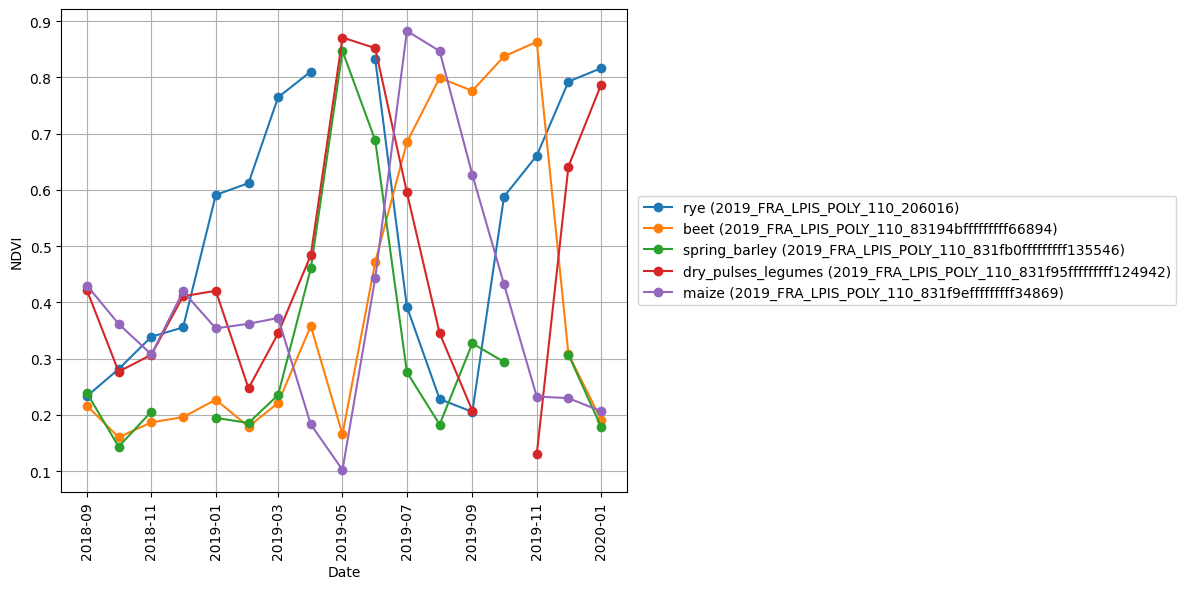

In [4]:
from notebook_utils.extractions import get_band_statistics, visualize_timeseries

subset = extractions_train[extractions_train['ref_id'] == '2019_FRA_LPIS_POLY_110']

# Check band statistics
band_stats = get_band_statistics(subset)

# Visualize timeseries for a few samples (5 by default)
visualize_timeseries(subset, nsamples=5, crop_label_attr='finetune_class')

You probably noticed that the data is composed of time series of Sentinel-2 optical imagery, Sentinel-1 radar imagery, temperature, precipitation, elevation and slope.

Also download the other data:
- additional training data for Latvia
- independent test data

In [5]:
# Dataset from Latvia, used for training the second model:
path_ds_latvia = datadir / "extractions" / "extractions_train_lva.parquet"
path_ds_latvia.parent.mkdir(exist_ok=True, parents=True)
if not path_ds_latvia.exists():
    print(f"Downloading training data to {path_ds_latvia}...")
    remote_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/extractions_train_lva.parquet"
    import urllib.request
    urllib.request.urlretrieve(remote_url, path_ds_latvia)
extractions_train_lva = pd.read_parquet(path_ds_latvia)
samples = extractions_train_lva.drop_duplicates(subset=['sample_id'])
print('Distribution of samples across years:')
print(samples['ref_id'].value_counts())

# Test datasets, used for assessing models' performance:
path_ds_test = datadir / "extractions" / "extractions_test.parquet"
path_ds_test.parent.mkdir(exist_ok=True, parents=True)
if not path_ds_test.exists():
    print(f"Downloading test data to {path_ds_test}...")
    remote_url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/extractions_test.parquet"
    import urllib.request
    urllib.request.urlretrieve(remote_url, path_ds_test)
extractions_test = pd.read_parquet(path_ds_test)
samples = extractions_test.drop_duplicates(subset=['sample_id'])
print('Distribution of samples across datasets:')
print(samples['ref_id'].value_counts())
print('Example data:')
print(extractions_test.head())

Distribution of samples across years:
ref_id
2021_LVA_LPIS_POLY_110    1095
Name: count, dtype: int64
Distribution of samples across datasets:
ref_id
2021_FRA_LPIS_POLY_110    1500
2021_LVA_LPIS_POLY_110    1095
Name: count, dtype: int64
Example data:
   feature_index                        sample_id  timestamp  S2-L2A-B02  \
0           3394  2021_FRA_LPIS_POLY_110_17097372 2020-09-01         278   
1           8002  2021_FRA_LPIS_POLY_110_19390306 2020-09-01         306   
2           9233  2021_FRA_LPIS_POLY_110_11901829 2020-09-01         735   
3           9455   2021_FRA_LPIS_POLY_110_2030371 2020-09-01         328   
4           9780   2021_FRA_LPIS_POLY_110_1934491 2020-09-01         603   

   S2-L2A-B03  S2-L2A-B04  S2-L2A-B05  S2-L2A-B06  S2-L2A-B07  S2-L2A-B08  \
0         646         354         987        3134        4000        4036   
1         524         304         724        3076        4059        4092   
2        1118        1148        1567        2566        284

Originally these training data are composed of multiple lines of data per sample, one line for each date for which satellite data has been extracted.

In the next cell, we convert this to a more condensed format and ensure that any sample with an observation date outside the growing season is discarded.

In [7]:
from openeo_gfmap import TemporalContext
from notebook_utils.extractions import map_classes
from notebook_utils.classifier import align_extractions_to_season

# In Europe, the center of the main spring season is situated around the month of June.
# WorldCereal models always require 12 months of input data.
# To inform the system about the season of interest, 
# we make sure the season center (June) is nicely aligned with 
# the center of the 12 month time period we define:
season = TemporalContext('2017-01-01', '2017-12-31')

# Align the data with the selected season
train_df = align_extractions_to_season(extractions_train, season=season)
train_lva_df = align_extractions_to_season(extractions_train_lva, season=season)
test_df = align_extractions_to_season(extractions_test, season=season)

# Now map the WorldCereal harmonized class labels to our classes of interest:
train_df = map_classes(train_df, class_mappings_csv)
train_lva_df = map_classes(train_lva_df, class_mappings_csv)
test_df = map_classes(test_df, class_mappings_csv)

print('Distribution of training data across crop types:')
print(train_df['finetune_class'].value_counts())


2026-02-09 14:01:50.039 | INFO     | worldcereal.utils.refdata:process_extractions_df:800 - Processing selected samples ...
2026-02-09 14:01:50.077 | INFO     | worldcereal.utils.refdata:process_extractions_df:819 - Aligning the samples with the user-defined temporal extent ...
2026-02-09 14:01:51.270 | WARNING  | worldcereal.utils.refdata:process_extractions_df:899 - Removed 2973 samples that do not fit into selected temporal extent:
  2018_FRA_LPIS_POLY_110: 2973
2026-02-09 14:01:51.309 | INFO     | worldcereal.utils.timeseries:process_parquet:1063 - Multiple ref_ids (3): required_min_timesteps not provided, setting based on freq='month'
2026-02-09 14:01:51.517 | INFO     | worldcereal.utils.timeseries:check_median_distance:357 - Multiple ref_ids (3): Expected observations frequency: month; Median observed distance between observations: [31] days
2026-02-09 14:01:53.657 | INFO     | worldcereal.utils.timeseries:fill_missing_dates:536 - Multiple ref_ids (3): All samples have the expec

ValueError: None of the samples matched the proposed temporal extent. Please select a different temporal extent.

Before proceeding with model training, let's group some classes together:

In [ ]:
combine_classes = {'winter_cereal': ['wheat', 'barley', 'rye'],
                   'spring_cereal': ['spring_wheat', 'spring_barley', 'spring_rye'],
                   'vegetables_tubers': ['vegetables_fruits', 'potatoes', 'beet'],
                   'other_crops': ['fibre_crops', 'dry_pulses_legumes', 'grass_fodder_crops'],
                   }

train_df['downstream_class'] = train_df['finetune_class']
train_lva_df['downstream_class'] = train_lva_df['finetune_class']
test_df['downstream_class'] = test_df['finetune_class']

for new_class, old_classes in combine_classes.items():
    train_df.loc[train_df['downstream_class'].isin(old_classes), 'downstream_class'] = new_class
    test_df.loc[test_df['downstream_class'].isin(old_classes), 'downstream_class'] = new_class
    train_lva_df.loc[train_lva_df['downstream_class'].isin(old_classes), 'downstream_class'] = new_class
    
train_df['downstream_class'].value_counts()


### 2. Computing training features using Presto

We do not feed entire satellite time series directly into a classification model. Instead, we unleash the power of a pre-trained geospatial foundation model (Presto) to summarize all information contained within the time series to a condensed and relevant set of 128 embeddings, specifically tuned for the task of crop mapping.<br>
<br>
For the training data, we apply additional data augmentation techniques:
- temporal jittering: introduce random backward or forward displacements in the time series to make the resulting model more robust against slight shifts in variation in seasonality (increasing temporal robustness).
- mask on training: applies sensor masking augmentations (e.g. simulating S1/S2 dropouts, introducing random additional clouds, removal of features) to make the model more robust against missing satellite and ancillary data.

In [ ]:
from notebook_utils.classifier import compute_presto_embeddings

train_embeddings_df = compute_presto_embeddings(train_df,
    augment=True,  # apply temporal jittering
    mask_on_training=True,  # apply sensor masking to training split
    repeats=3  # number of times to augment each training sample
)
train_lva_embeddings_df = compute_presto_embeddings(train_lva_df,
    augment=True,  # apply temporal jittering
    mask_on_training=True,  # apply sensor masking to training split
    repeats=3  # number of times to augment each training sample
)
test_embeddings_df = compute_presto_embeddings(test_df,
    augment=False,  # apply temporal jittering
    mask_on_training=False,  # apply sensor masking to training split
    repeats=1
)

### 3. Train and test classifiers

Let's train our first model, purely based on French training data (`train_embeddings_df`):

In [ ]:
from notebook_utils.classifier import train_classifier

model_1, report_1, cm_tmp = train_classifier(
    train_embeddings_df, 
    balance_classes=True, 
    show_confusion_matrix='relative',
)

We check the performance on our independent test sets:
1. France 2021
2. Latvia 2021

In [ ]:
# Check performance on independent test sets
from notebook_utils.classifier import apply_classifier

# We split the test set according to dataset
test_df_FR = test_embeddings_df.loc[test_embeddings_df['ref_id'].str.contains('_FRA_')]
test_df_LVA = test_embeddings_df.loc[test_embeddings_df['ref_id'].str.contains('_LVA_')]

report_val_FR, cm_val_FR, pred = apply_classifier(
    test_df_FR,
    model_1,
    show_confusion_matrix='relative',
    print_report=True,
)

report_val_LVA, cm_val_LVA, pred = apply_classifier(
    test_df_LVA,
    model_1,
    show_confusion_matrix='relative',
    print_report=True,
)

We notice very good performance on the French data (average f1 score of 0.82, which is nearly the same as the one obtained on the training data - 0.84). This effectively demonstrates temporal robustness of our model: as long as we train on multiple years, it is safe to apply the model to an unseen year in the same region.<br>

At the same time, we notice significantly worse performance on the Latvian data (average f1 score of 0.66, with main confusion between vegetables_tubers and other crops).

Transferring a model from one region to another is quite risky, as dominant crop types, cropping patterns, farming practices and environmental conditions can differ substantially.

Now let's train a second model using a combination of French and Latvian training data and immediately apply it to the Latvian test dataset.

In the first line of the code, you can control how many samples from the Latvian data get randomly added to the French data...
(recall we originally had 1000 samples, but we artifially increased this to 3000 due to augmentation, so you can pick any number between 1 and 3000)

In [ ]:
latvian_data = train_lva_embeddings_df.sample(1000)
combined_embeddings_df = pd.concat([train_embeddings_df, latvian_data], ignore_index=True)

model_2, report_2, cm_tmp = train_classifier(
    combined_embeddings_df, 
    balance_classes=True, 
    show_confusion_matrix=None,
)

report_val_LVA, cm_val_LVA, pred = apply_classifier(
    test_df_LVA,
    model_2,
    show_confusion_matrix='relative',
    print_report=True,
)

Adding just 500 samples raised f1 score from 0.66 to 0.73.
Adding 1000 resulted in f1 score of 0.75.
Adding all available Latvian data increases performance further to 0.79!

This clearly demonstrates that gradually adding more local training data significantly boosts the classification model's performance!

Let's have a look at the composition of the training data again:

In [ ]:
print(combined_embeddings_df.ref_id.value_counts())
pct = len(latvian_data) / len(combined_embeddings_df) * 100
print(f'Total number of samples: {len(combined_embeddings_df)}')
print(f'Percentage of Latvian samples: {pct:.2f}%')


### 4. Generate maps

Now that we have a model, let's apply it to some test patches and see how the resulting maps look like.

To apply our model, we need to deploy our model to your private bucket on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/). Make sure to register for a free account if you haven't done so.

Upon execution of the next cell, click the link below the cell to authenticate with your credentials.

In [ ]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection

modelname = 'France_multiyear_Latvia'
model_url = deploy_model(cdse_connection(), model_2, pattern=modelname)
print(f"Your model can be downloaded from: {model_url}")

We have prepared one test patch in France and one test patch in Latvia for you to apply the model to.<br>
Upon execution of the next cell, these test patches will be automatically downloaded to the "maps" subdirectory.<br>

Once downloaded, the `run_full_croptype_inference_workflow` will do the following:
1. compute Presto embeddings finetuned for the task of land cover mapping for each pixel in the patch
2. apply the default global WorldCereal cropland model to these embeddings, resulting in a distinction between temporary crops and other land cover
3. compute Presto embeddings finetuned for the task of crop type mapping for each pixel in the patch
4. apply your custom crop type model you just trained to generate a crop type map
5. mask the crop type product using the cropland mask generated in step 2.

Test patches are approx. 10 x 10 km in size. The full pipeline for one patch takes around 10-15 mins.

In [ ]:
from notebook_utils.local_inference import run_full_croptype_inference_workflow

test_sites = [
    # 'france', 
    'latvia']

outdir = Path('./maps')
outdir.mkdir(exist_ok=True, parents=True)

inputs = {}
for site in test_sites:
    site_dir = outdir / site
    site_dir.mkdir(exist_ok=True, parents=True)
    input_path = site_dir / 'preprocessed_inputs.nc'
    if not input_path.exists():
        print(f"Downloading preprocessed inputs to {input_path}...")
        remote_url = f"https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/demo/{site}_preprocessed-inputs_2021-01-01_2021-12-31.nc"
        import urllib.request
        urllib.request.urlretrieve(remote_url, input_path)
    inputs[site] = input_path

output_paths = run_full_croptype_inference_workflow(inputs, outdir, model_url)

The resulting maps are automatically stored in the "maps" subdirectory.<br>
You can inspect the resulting maps in QGIS, or use the following cell for a quick visualization.<br>

The resulting crop type raster will contain multiple bands:
- Band 1: "classification": The classification label of the pixel.
- Band 2: "confidence": The class-specific probablity of the winning class.
- Band 3 and beyond: "probability_xxx": Class-specific probablities. The "xxx" indicates the associated class.

Upon running the next cell, two additional GeoTiff files will be generated, one showing the classification and the other showing the probability of the winning class. These maps receive standardized styling, enabling quick visualization.

In [ ]:
from notebook_utils.visualization import visualize_product
from worldcereal.utils.models import load_model_lut

site = 'latvia'
# site = 'france'
croptype_path = output_paths[site]['croptype']

lut = load_model_lut(model_url)
# the look-up table is needed to interprete the raster values of the classification band...
print(lut)

# Visualize the product here using matplotlib...
visualize_product(croptype_path, product='croptype', lut=lut)

To give you an idea about the actual crops in both regions, here is a screenshot of the two areas with crop types colored according to the following scheme:
- winter cereals = darkish brown
- spring cereals = orange
- maize = yellow
- soybean = red
- rapeseed = cyan
- vegetables/tubers = blue
- sunflower = purple
- other crops = pink
- grassland & permanent crops = green

FRANCE:

<img src="./resources/france_validation.png" alt="France crop type validation" width="600">

LATVIA:

<img src="./resources/latvia_validation.png" alt="Latvia crop type validation" width="600">

Congratulations, you have reached the end of this demo!

Want to know more after this session?

- Check the [WorldCereal documentation](https://worldcereal.github.io/worldcereal-documentation/)
- Ask questions on our [user forum](https://forum.esa-worldcereal.org/)
- Subscribe to our [newsletter](https://esa-worldcereal.org/en#news) to get the latest updates
- Follow us on [LinkedIn](https://www.linkedin.com/company/esa-worldcereal)!